/var/folders/jb/lm0z_qbj3614t6yq_5ygbhvr0000gn/T/ipykernel_86559/2685016399.py:38: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  aligned_df = df.reindex(common_timestamps).interpolate(method='linear').reset_index()


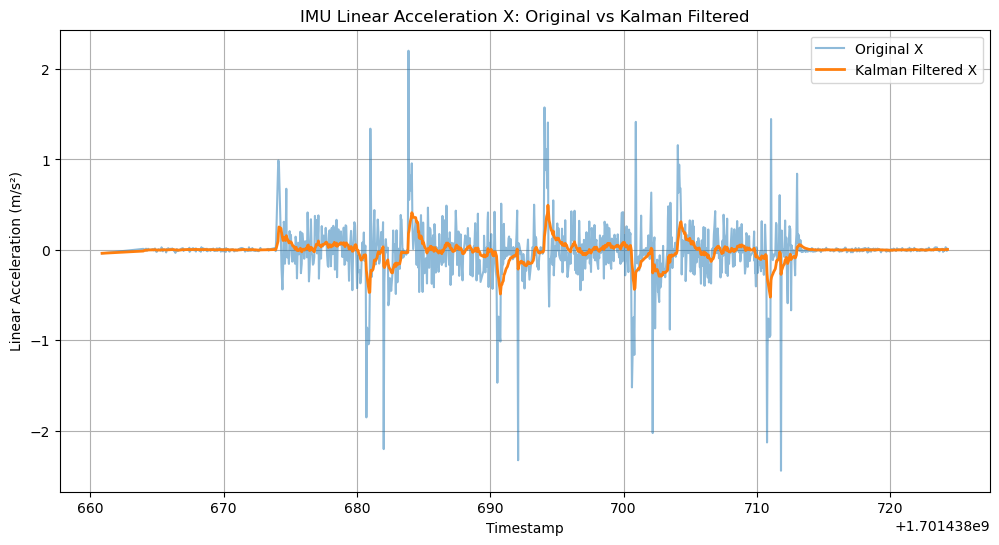

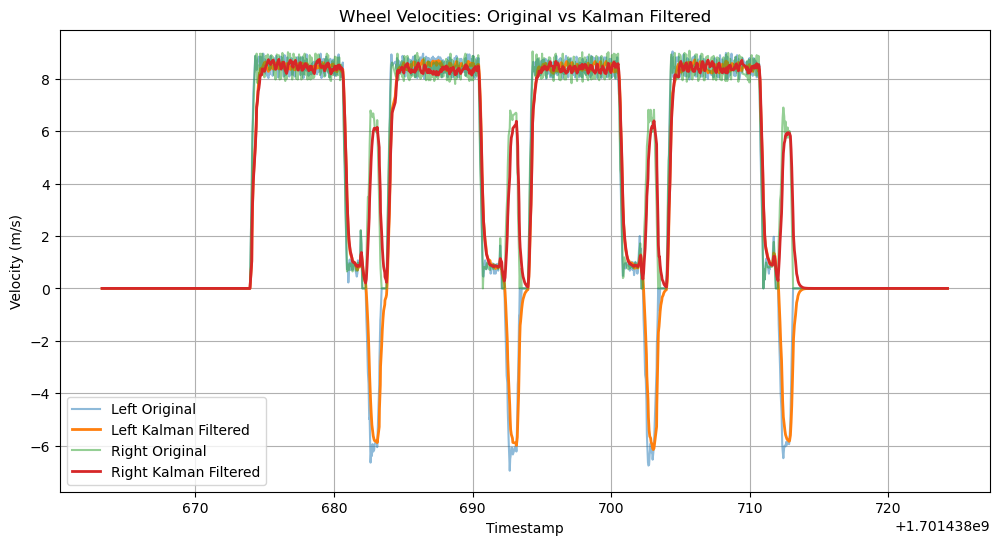

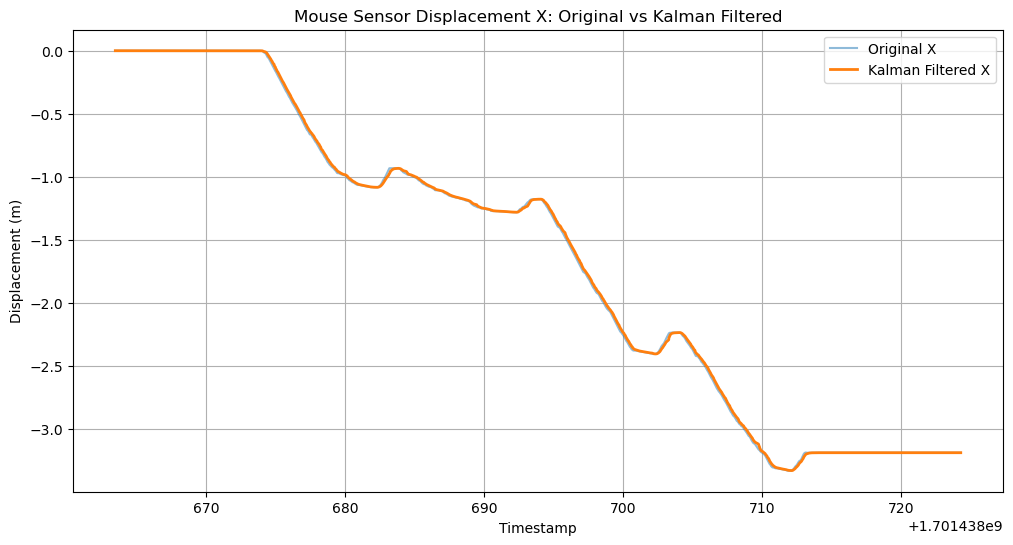

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Constants
wheel_radius = 0.072 / 2  # Radius of the wheel (meters)
wheel_base = 0.235        # Distance between wheels (meters)
ticks_per_revolution = 508.8
data_limit = 953          # Set to -1 for no limit on data

# Load the datasets
imu_data = pd.read_csv('./DFA_Assignment3_2024/imu_data.csv')
mouse_data = pd.read_csv('./DFA_Assignment3_2024/mouse_data.csv')
wheel_status_data = pd.read_csv('./DFA_Assignment3_2024/wheel_status_data.csv')
wheel_ticks_data = pd.read_csv('./DFA_Assignment3_2024/wheel_ticks_data.csv')
wheel_vels_data = pd.read_csv('./DFA_Assignment3_2024/wheel_vels_data.csv')
tf_data = pd.read_csv('./DFA_Assignment3_2024/tf_data.csv')  # Ground truth

# Combine seconds and nanoseconds into a single timestamp (in seconds with fractional part)
def create_full_timestamp(df, sec_col, nsec_col):
    df['full_timestamp'] = df[sec_col] + df[nsec_col] * 1e-9
    return df

# Apply to all datasets
imu_data = create_full_timestamp(imu_data, 'timestamp_sec', 'timestamp_nanosec')
mouse_data = create_full_timestamp(mouse_data, 'timestamp_sec', 'timestamp_nanosec')
tf_data = create_full_timestamp(tf_data, 'timestamp_sec', 'timestamp_nanosec')
wheel_status_data = create_full_timestamp(wheel_status_data, 'timestamp_sec', 'timestamp_nanosec')
wheel_ticks_data = create_full_timestamp(wheel_ticks_data, 'timestamp_sec', 'timestamp_nanosec')
wheel_vels_data = create_full_timestamp(wheel_vels_data, 'timestamp_sec', 'timestamp_nanosec')

# Align datasets on a common time base derived from TF data (ground truth)
common_timestamps = tf_data['full_timestamp']

def align_to_common_timestamps(df, common_timestamps, columns_to_interpolate):
    df = df.set_index('full_timestamp')
    aligned_df = df.reindex(common_timestamps).interpolate(method='linear').reset_index()
    aligned_df = aligned_df.rename(columns={'index': 'full_timestamp'})
    return aligned_df[columns_to_interpolate + ['full_timestamp']]

imu_aligned = align_to_common_timestamps(imu_data, common_timestamps, imu_data.columns.drop(['timestamp_sec', 'timestamp_nanosec', 'full_timestamp']).tolist())
mouse_aligned = align_to_common_timestamps(mouse_data, common_timestamps, mouse_data.columns.drop(['timestamp_sec', 'timestamp_nanosec', 'full_timestamp']).tolist())
wheel_status_aligned = align_to_common_timestamps(wheel_status_data, common_timestamps, wheel_status_data.columns.drop(['timestamp_sec', 'timestamp_nanosec', 'full_timestamp']).tolist())
wheel_ticks_aligned = align_to_common_timestamps(wheel_ticks_data, common_timestamps, wheel_ticks_data.columns.drop(['timestamp_sec', 'timestamp_nanosec', 'full_timestamp']).tolist())
wheel_vels_aligned = align_to_common_timestamps(wheel_vels_data, common_timestamps, wheel_vels_data.columns.drop(['timestamp_sec', 'timestamp_nanosec', 'full_timestamp']).tolist())

# Combine aligned datasets for easier access
aligned_data = {
    'imu_aligned': imu_aligned,
    'mouse_aligned': mouse_aligned,
    'wheel_status_aligned': wheel_status_aligned,
    'wheel_ticks_aligned': wheel_ticks_aligned,
    'wheel_vels_aligned': wheel_vels_aligned,
    'tf_data': tf_data
}

# Kalman filter implementation for 1D data smoothing
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, initial_estimate=0, initial_uncertainty=1):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimate = initial_estimate
        self.uncertainty = initial_uncertainty

    def update(self, measurement):
        # Prediction step
        self.uncertainty += self.process_variance

        # Update step
        kalman_gain = self.uncertainty / (self.uncertainty + self.measurement_variance)
        self.estimate += kalman_gain * (measurement - self.estimate)
        self.uncertainty *= (1 - kalman_gain)

        return self.estimate

# Apply Kalman Filter for data smoothing

# IMU linear acceleration
imu_kf_x = KalmanFilter(process_variance=1e-4, measurement_variance=1e-2)
imu_kf_y = KalmanFilter(process_variance=1e-4, measurement_variance=1e-2)
imu_data['kf_linear_acceleration_x'] = imu_data['linear_acceleration_x'].apply(
    lambda x: imu_kf_x.update(x) if not np.isnan(x) else np.nan
)
imu_data['kf_linear_acceleration_y'] = imu_data['linear_acceleration_y'].apply(
    lambda x: imu_kf_y.update(x) if not np.isnan(x) else np.nan
)

# Wheel velocities
wheel_vels_kf_left = KalmanFilter(process_variance=1e-3, measurement_variance=1e-2)
wheel_vels_kf_right = KalmanFilter(process_variance=1e-3, measurement_variance=1e-2)
wheel_vels_data['kf_velocity_left'] = wheel_vels_data['velocity_left'].apply(
    lambda x: wheel_vels_kf_left.update(x) if not np.isnan(x) else np.nan
)
wheel_vels_data['kf_velocity_right'] = wheel_vels_data['velocity_right'].apply(
    lambda x: wheel_vels_kf_right.update(x) if not np.isnan(x) else np.nan
)

# Mouse sensor displacement
mouse_kf_x = KalmanFilter(process_variance=1e-3, measurement_variance=1e-2)
mouse_kf_y = KalmanFilter(process_variance=1e-3, measurement_variance=1e-2)
mouse_data['kf_integrated_x'] = mouse_data['integrated_x'].apply(
    lambda x: mouse_kf_x.update(x) if not np.isnan(x) else np.nan
)
mouse_data['kf_integrated_y'] = mouse_data['integrated_y'].apply(
    lambda x: mouse_kf_y.update(x) if not np.isnan(x) else np.nan
)

# Plotting the smoothed data for validation
plt.figure(figsize=(12, 6))
plt.title("IMU Linear Acceleration X: Original vs Kalman Filtered")
plt.plot(imu_data['full_timestamp'], imu_data['linear_acceleration_x'], label='Original X', alpha=0.5)
plt.plot(imu_data['full_timestamp'], imu_data['kf_linear_acceleration_x'], label='Kalman Filtered X', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Linear Acceleration (m/s²)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Wheel Velocities: Original vs Kalman Filtered")
plt.plot(wheel_vels_data['full_timestamp'], wheel_vels_data['velocity_left'], label='Left Original', alpha=0.5)
plt.plot(wheel_vels_data['full_timestamp'], wheel_vels_data['kf_velocity_left'], label='Left Kalman Filtered', linewidth=2)
plt.plot(wheel_vels_data['full_timestamp'], wheel_vels_data['velocity_right'], label='Right Original', alpha=0.5)
plt.plot(wheel_vels_data['full_timestamp'], wheel_vels_data['kf_velocity_right'], label='Right Kalman Filtered', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Mouse Sensor Displacement X: Original vs Kalman Filtered")
plt.plot(mouse_data['full_timestamp'], mouse_data['integrated_x'], label='Original X', alpha=0.5)
plt.plot(mouse_data['full_timestamp'], mouse_data['kf_integrated_x'], label='Kalman Filtered X', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Displacement (m)")
plt.legend()
plt.grid()
plt.show()



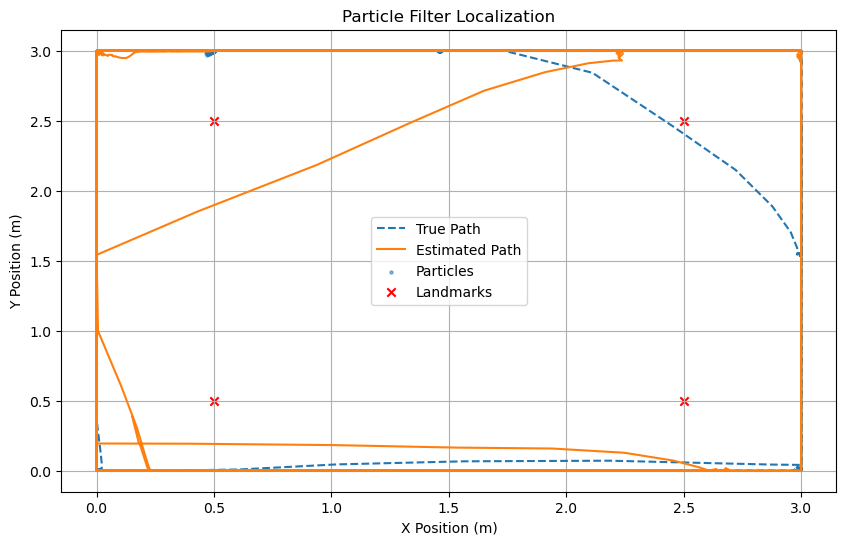

In [30]:
# Particle Filter Implementation with 3x3 bounded area
class ParticleFilter:
    def __init__(self, num_particles, x_range, y_range, theta_range, landmarks):
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, 3))  # Each particle has (x, y, theta)
        self.weights = np.ones(num_particles) / num_particles  # Uniform weights
        self.landmarks = np.array(landmarks)  # Landmarks in the environment

        # Initialize particles uniformly within the 3x3 area
        self.particles[:, 0] = np.random.uniform(x_range[0], x_range[1], num_particles)  # x
        self.particles[:, 1] = np.random.uniform(y_range[0], y_range[1], num_particles)  # y
        self.particles[:, 2] = np.random.uniform(theta_range[0], theta_range[1], num_particles)  # theta

    def predict(self, v, omega, dt, motion_noise):
        """Move particles based on motion model."""
        noise_v = np.random.normal(0, motion_noise[0], self.num_particles)
        noise_omega = np.random.normal(0, motion_noise[1], self.num_particles)

        v_noisy = v + noise_v
        omega_noisy = omega + noise_omega

        self.particles[:, 0] += v_noisy * dt * np.cos(self.particles[:, 2])
        self.particles[:, 1] += v_noisy * dt * np.sin(self.particles[:, 2])
        self.particles[:, 2] += omega_noisy * dt
        self.particles[:, 2] = (self.particles[:, 2] + np.pi) % (2 * np.pi) - np.pi  # Normalize theta

        # Constrain particles to the 3x3 area
        self.particles[:, 0] = np.clip(self.particles[:, 0], x_range[0], x_range[1])
        self.particles[:, 1] = np.clip(self.particles[:, 1], y_range[0], y_range[1])

    def update(self, measurements, measurement_noise):
        """Update particle weights based on measurements."""
        for i, particle in enumerate(self.particles):
            distances = np.linalg.norm(self.landmarks - particle[:2], axis=1)
            self.weights[i] = np.exp(-0.5 * np.sum(((measurements - distances) / measurement_noise) ** 2))

        self.weights += 1e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)

    def resample(self):
        """Resample particles based on their weights."""
        positions = (np.arange(self.num_particles) + np.random.uniform(0, 1)) / self.num_particles
        cumulative_sum = np.cumsum(self.weights)
        indexes = np.searchsorted(cumulative_sum, positions)
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """Estimate state as the weighted mean of particles."""
        mean_x = np.average(self.particles[:, 0], weights=self.weights)
        mean_y = np.average(self.particles[:, 1], weights=self.weights)
        mean_theta = np.arctan2(
            np.sum(np.sin(self.particles[:, 2]) * self.weights),
            np.sum(np.cos(self.particles[:, 2]) * self.weights)
        )
        return mean_x, mean_y, mean_theta


# Simulated landmarks within 3x3 area
landmarks = [(0.5, 0.5), (0.5, 2.5), (2.5, 0.5), (2.5, 2.5)]  # Example landmarks

# Initialize Particle Filter for 3x3 meter area
x_range = (0, 3)
y_range = (0, 3)
pf = ParticleFilter(
    num_particles=500,
    x_range=x_range,
    y_range=y_range,
    theta_range=(-np.pi, np.pi),
    landmarks=landmarks
)

# Simulation parameters
dt = 0.1  # Time step
motion_noise = [0.05, 0.02]  # Motion noise for v and omega
measurement_noise = 0.2  # Measurement noise for landmark distances

# Initialize states
true_state = [0, 0, 0]  # Initial state (x, y, theta) 
true_states = []
estimated_states = []

# Main Particle Filter Simulation
for t in range(len(wheel_vels_data)):
    # Use Kalman-filtered wheel velocities
    v = (wheel_vels_data['kf_velocity_left'].iloc[t] + wheel_vels_data['kf_velocity_right'].iloc[t]) / 2
    omega = (wheel_vels_data['kf_velocity_right'].iloc[t] - wheel_vels_data['kf_velocity_left'].iloc[t]) / wheel_base

    # Update true state
    theta = true_state[2]
    x_new = true_state[0] + v * dt * np.cos(theta)
    y_new = true_state[1] + v * dt * np.sin(theta)
    theta_new = theta + omega * dt
    theta_new = (theta_new + np.pi) % (2 * np.pi) - np.pi  # Normalize theta

    # Constrain true state to 3x3 area
    x_new = np.clip(x_new, x_range[0], x_range[1])
    y_new = np.clip(y_new, y_range[0], y_range[1])

    true_state = [x_new, y_new, theta_new]
    true_states.append(true_state)

    # Simulated measurements to landmarks
    distances_to_landmarks = np.linalg.norm(np.array(landmarks) - np.array([x_new, y_new]), axis=1)
    measurements = distances_to_landmarks + np.random.normal(0, measurement_noise, len(landmarks))

    # Particle Filter steps
    pf.predict(v, omega, dt, motion_noise)
    pf.update(measurements, measurement_noise)
    pf.resample()

    # Estimate state
    estimated_state = pf.estimate()
    estimated_states.append(estimated_state)

# Convert to arrays for plotting
true_states = np.array(true_states)
estimated_states = np.array(estimated_states)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path", linestyle="--")
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label="Estimated Path")
plt.scatter(pf.particles[:, 0], pf.particles[:, 1], s=5, alpha=0.5, label="Particles")
plt.scatter(*zip(*landmarks), c='red', label="Landmarks", marker='x')
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Particle Filter Localization")
plt.legend()
plt.grid()
plt.show()


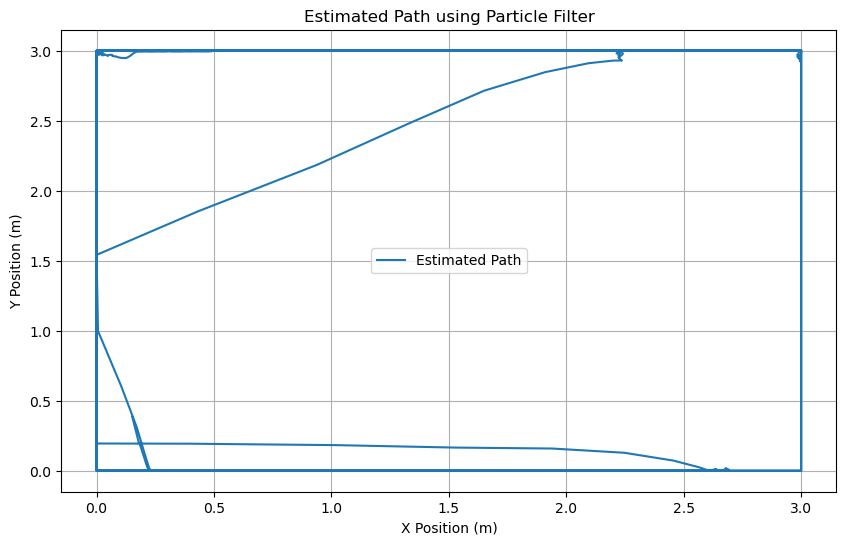

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label="Estimated Path")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Estimated Path using Particle Filter")
plt.legend()
plt.grid()
plt.show()

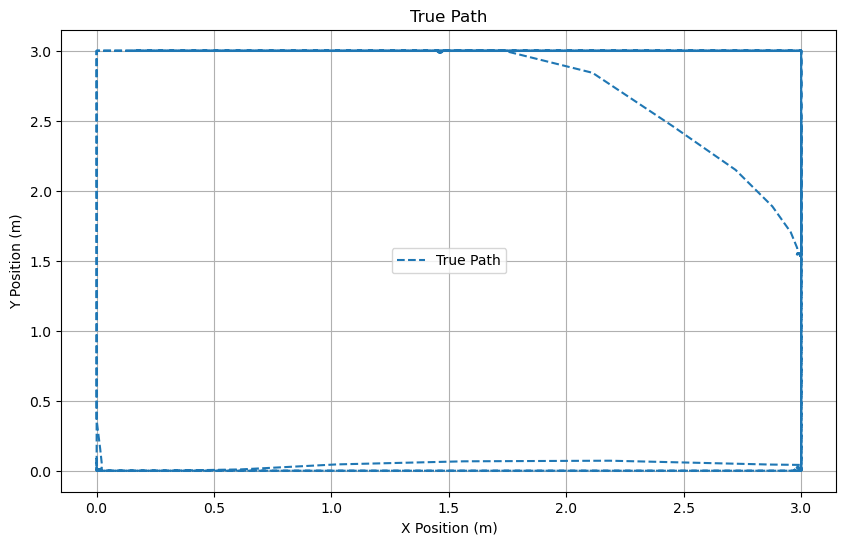

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path", linestyle="--")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("True Path")
plt.legend()
plt.grid()
plt.show()